### Analysis of trained models

This notenook can be used to perform basic analysis of our models : 
- explore the latent space like in Schmidhuber world model paper.
- look at different SPE metric for 4 different disruptions of "flow" : position glitch, digit identity glitch, speed glitch & effect of bouncing. 

In [158]:
%matplotlib inline
import numpy as np
import random
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout


# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import sys
sys.path.append("../models")
from vae_64_64 import VAE_64_64
from mdrnn import MDRNN
from vrnn import VRNN

sys.path.append("../utils")
from plot_functions import plot_video_comparison,plot_SPE_metrics


cuda


In [159]:
# import data from the moving mnist dataset
data_sequential = np.load('../../data/MNIST/bouncing_mnist_test.npy')
data_sequential = data_sequential / 255
data = data_sequential.reshape((200000,1,64,64)) # we split the 10000 video of 20 frames into 200000 images of 64x64 pixels

### VAE module

In [160]:
vae_model_path = '../../saved_models/MNIST/model_vae_2023-05-04.pt'
vae_params_path_recovery = vae_model_path[:-3]+'.params.yml'
with open(vae_params_path_recovery) as file :
    vae_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+vae_params_path_recovery)
print("beta params :",vae_parameters['beta_vae'])

vae_model = VAE_64_64(img_channels=vae_parameters['img_channels_vae'],
                     latent_dim=vae_parameters['latent_dim_vae'],
                     beta=vae_parameters['beta_vae']).to(device)

vae_model.load_state_dict(torch.load(vae_model_path))
vae_model.eval()

using parameters from ../../saved_models/MNIST/model_vae_2023-05-04.params.yml
beta params : 1


VAE_64_64(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (fc_mu): Linear(in_features=1024, out_features=20, bias=True)
    (fc_logsigma): Linear(in_features=1024, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=256, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
  )
)

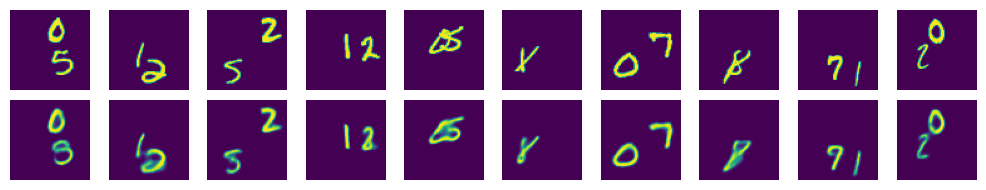

In [161]:
imgs = np.array(random.sample(list(data), 10))
imgs_tensor = torch.tensor(imgs).to(device).float()
out_tensor, mu, logsigma = vae_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(1),out.squeeze(1))


In [162]:
'''

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = vae_model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = mu.shape[1]
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))
'''

'\n\n%matplotlib widget\nfig = plt.figure()\nax = fig.add_subplot(1, 1, 1)\n\ndef plot_latent(**kwargs):\n    """\n    Print the current widget value in short sentence\n    """\n    z = []\n    for z_i in locals()[\'kwargs\']:\n        z.append(locals()[\'kwargs\'][z_i])\n    z = torch.tensor(z).unsqueeze(0).float().to(device)\n    out = vae_model.decoder_pass(z)\n    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])\n    ax.imshow(np.squeeze(outimg))\n    ax.set_axis_off()\n    fig.canvas.draw()\n    \nlatent_dim = mu.shape[1]\nlatent_variables_init = {}\nfor i in range(latent_dim):\n    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()\nw = widgets.interactive(plot_latent,**latent_variables_init)\nfor slider in w.children:\n    slider.min = -4\n    slider.max = 4\n    slider.orientation=\'vertical\'\n    slider.layout = Layout(width=\'90%\')\n\ndisplay(HBox(w.children))\n'

### Full "world model"

In [163]:
mdrnn_model_path = '../../saved_models/MNIST/model_mdrnn_2023-05-04.pt'
mdrnn_params_path_recovery = mdrnn_model_path[:-3]+'.params.yml'
with open(mdrnn_params_path_recovery) as file :
    mdrnn_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+mdrnn_params_path_recovery)

mdrnn_model = MDRNN(latent_dim=mdrnn_parameters['latent_dim_mdrnn'],
            action_dim=mdrnn_parameters['action_dim_mdrnn'],
            hidden_dim=mdrnn_parameters['hidden_dim_mdrnn'],
            gaussians_nb=mdrnn_parameters['gaussians_nb_mdrnn']).to(device)
mdrnn_model.load_state_dict(torch.load(mdrnn_model_path))
mdrnn_model.eval()

using parameters from ../../saved_models/MNIST/model_mdrnn_2023-05-04.params.yml


MDRNN(
  (gmm_linear): Linear(in_features=128, out_features=41, bias=True)
  (rnn): RNN(22, 128)
)

In [164]:
def run_model_prediction(video):
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,64,64)).float().to(device)
    _,latent_video, latent_video_variance  = vae_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    # reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,64,64))

    if mdrnn_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device),
                        torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device))
    action = torch.zeros(batch_size, 2).to(device)

    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]

        if mdrnn_model.memory == 'rnn':
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden

        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    mean_pred = torch.tensor(mean_pred).to(device)
    predicted_video = vae_model.decoder_pass(torch.reshape(mean_pred,(-1,latent_dim)))
    predicted_video = torch.reshape(predicted_video,(seq_len,batch_size,64,64)).cpu().detach().numpy().transpose((1,0,2,3))

    mean_pred = mean_pred.cpu().detach().numpy().transpose((1,0,2))
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    # reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return predicted_video,latent_video, latent_video_variance, mean_pred, sig_pred

In [165]:
random_index_1 = np.random.randint(10000,size=100)
random_index_2 = np.random.randint(10000,size=100)
video = data_sequential[random_index_1,:]
index_shuffle = [list(np.random.randint(10,size=10)) for i in range(300)]

video = np.concatenate((data_sequential[random_index_1,:10],data_sequential[random_index_2,:10]),axis=1) 

reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(video)

0.0011189431 1.8654062


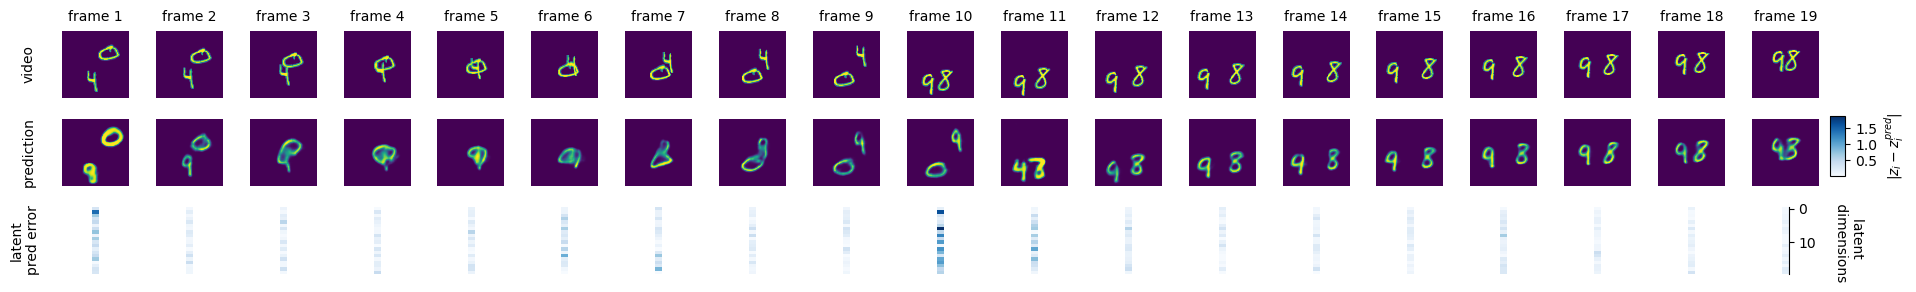

In [169]:
vmin = (mean_pred[0][:-1] - latent_video[0][1:]).min()
vmax = (mean_pred[0][:-1] - latent_video[0][1:]).max()


def plot_video_comparison(video, reconstructed_video,latent_var=False,latent_pred_error=None):

    vmin = latent_pred_error.min()
    vmax = latent_pred_error.max()
    print(vmin,vmax)
    nb_frame = video.shape[0]
    if latent_var :
        fig, ax = plt.subplots(3, nb_frame, figsize=(nb_frame, 3))
    else :
        fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
        ax[0, i].annotate('frame '+str(i+1),
            xy=(0.5, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='bottom')
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    
    for i in range(video.shape[0]):
        im = ax[2, i].imshow(latent_pred_error[i:i+1,:].T,aspect=0.5,vmin=vmin,vmax=vmax,cmap='Blues')
        ax[2, i].axis("off")

    ax[0, 0].annotate('video',
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[1, 0].annotate('prediction',
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[2, 0].annotate('latent\npred error',
            xy=(-10, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')
    ax[2, -1].annotate('latent \n dimensions',
            xy=(10, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation=270)
    ax[2, -1].axis("on")
    ax[2, -1].yaxis.tick_right()
    ax[2, -1].xaxis.set_visible(False)
    ax[2, -1].spines[['left','bottom','top']].set_visible(False)

    fig.tight_layout()

    cax = fig.add_axes([0.97, .4, 0.008, 0.2])
    fig.colorbar(im, orientation="vertical", pad=0.2,cax=cax,label=r'$|z_i - z_i^{pred}|$')
    plt.show()

    fig.savefig('latent_pred_error.pdf',bbox_inches='tight')

sample = 2
plot_video_comparison(video[sample][1:],reconstructed_video[sample][:-1],latent_var=True,latent_pred_error= np.abs(mean_pred[sample][:-1] - latent_video[sample][1:]))

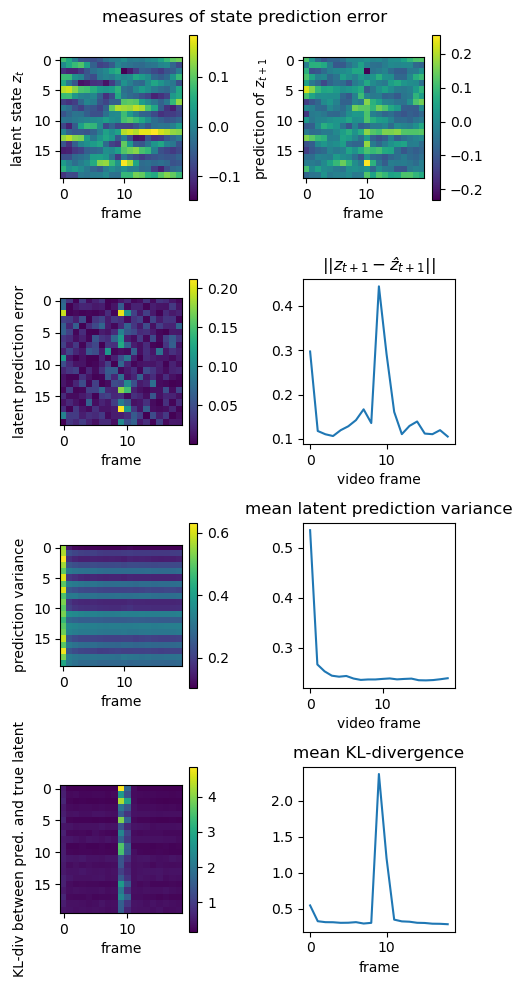

In [12]:
plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred)

In [171]:
data_path = "../../data/MNIST/"
data_files = [
    "standard.npy", 
    "random_position_glitch.npy",
    "offset_position_glitch.npy",
    "digit_glitch.npy",
    "position_and_digit_glitch.npy",
    "reverse_direction_glitch.npy",
    "random_direction_glitch.npy",
    "speed_glitch.npy",
    "timed_bounce.npy",
]

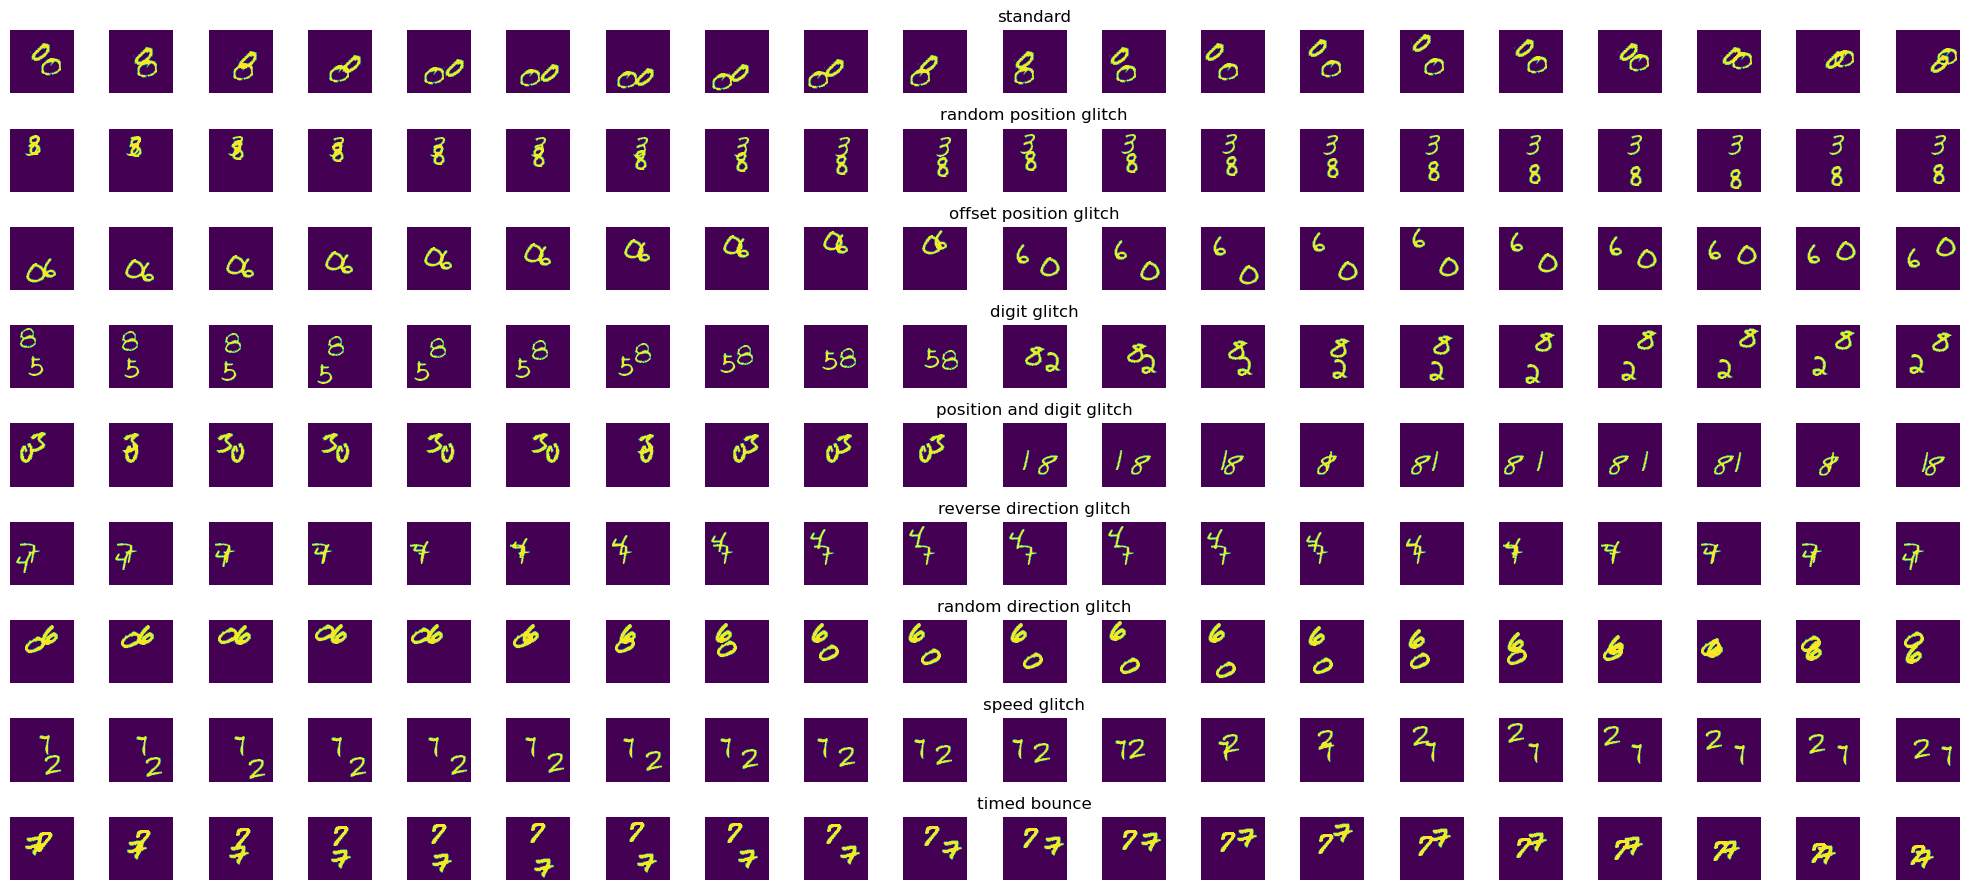

In [170]:
fig, axs = plt.subplots(len(data_files),20,figsize=(20,len(data_files)))

for i, (file,axs_file) in enumerate(zip(data_files,axs)):
    data = np.load(data_path + file)
    video = data[np.random.randint(100)]
    axs_file[10].set_title(file.split(".")[0].replace('_',' '))

    for frame, ax in enumerate(axs_file):
        ax.imshow(video[frame,:,:])
        ax.axis('off')

fig.tight_layout()
plt.show()

fig.savefig('glitch_examples.pdf',bbox_inches='tight')

0.11047608 0.66529346
(11, 0)
0.11233469 0.9761448
(2, 4)
0.1091002 1.1088918
(2, 4)
0.1058004 0.6740278
(4, 4)
0.09357963 0.93856585
(2, 4)
0.10288511 0.6329755
(7, 5)
0.10290492 0.59074867
(7, 5)
0.1060506 0.7938466
(17, 11)
0.09242718 0.56569666
(2, 0)


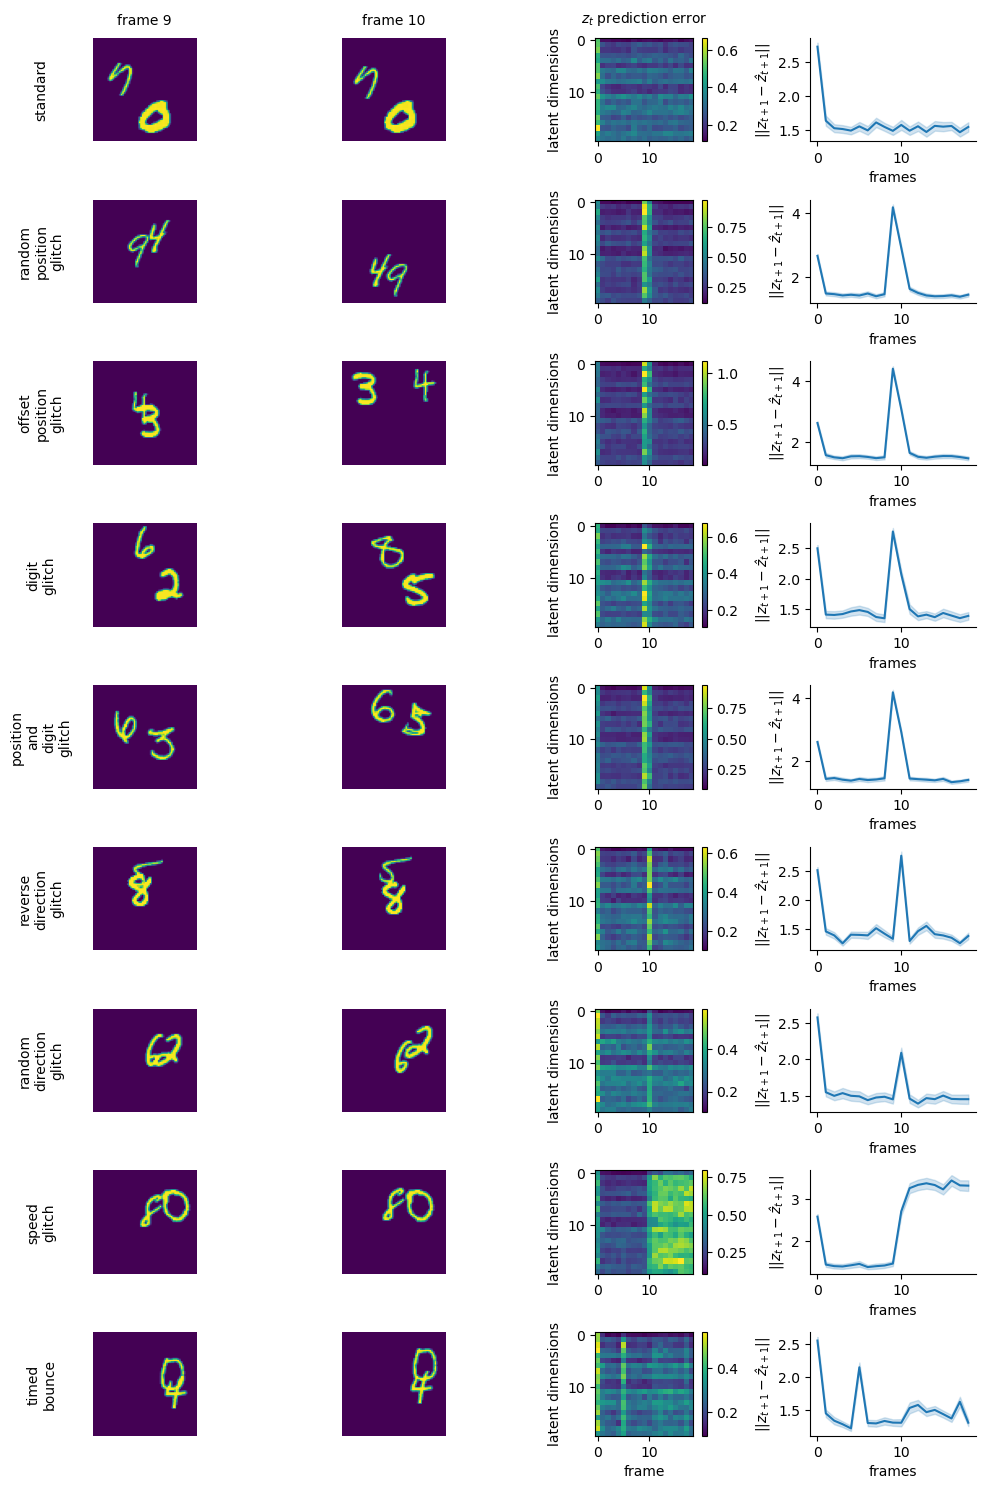

In [172]:
import scipy.stats
import seaborn as sns
fig, axs = plt.subplots(len(data_files),4,figsize=(10,15))

vmin=0.0
vmax=1.

dict_lspe_val = {}

list_timesteps_obs = [9,9,9,9,9,10,10,10,5]

for i, (file,axs_file) in enumerate(zip(data_files,axs)):
    data = np.load(data_path + file)
    data = data / 255
    reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(data)

    z = np.mean(latent_video,axis=0).T
    z_pred = np.mean(mean_pred,axis=0).T

    array = mean_pred[:,:-1,:] -  latent_video[:,1:,:]

    # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
    z_error = np.mean( np.abs(mean_pred[:,:-1,:] - latent_video[:,1:,:]),axis=0).T


    print(z_error.min(),z_error.max())

    
    z_error_norm = np.mean( np.linalg.norm(array,axis=-1) ,axis=0) # first we compute the norm || z_t+1 , z_t || for every t and every sequence (100,19,32) => (100,19) and then we average it across sequences (100,19) => (,19)

    print(np.unravel_index(np.argmax(z_error[:,5:], axis=None), z_error[:,5:].shape))

    dict_lspe_val[file.split(".")[0]] = np.max( np.linalg.norm(array,axis=-1)[:,list_timesteps_obs],axis=1)

    err = np.std(np.linalg.norm(array,axis=-1),axis=0)

    axs_file[0].annotate(file.split(".")[0].replace("_", "\n" ),
            xy=(-0.5, 0.5), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',rotation='vertical')

    axs_file[0].imshow(data[0,9,:,:])
    axs_file[0].set_axis_off()

    axs_file[1].imshow(data[0,10,:,:])
    axs_file[1].set_axis_off()

    im = axs_file[2].imshow(z_error) # ,vmin=vmin,vmax=vmax)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axs_file[2])# mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    if i == len(data_files) - 1 :
        axs_file[2].set_xlabel('frame')
        
    axs_file[2].set_ylabel('latent dimensions')
    if i == 0 :
        axs_file[0].annotate(r'frame 9',
            xy=(0.5, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='bottom')
        axs_file[1].annotate(r'frame 10',
            xy=(0.5, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='bottom')
        axs_file[2].annotate(r'$z_t$ prediction error',
            xy=(0.5, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='bottom')

    # axs_file[3].plot(z_error_norm)
    sns.lineplot(x =  np.tile(np.arange(19),np.linalg.norm(array,axis=-1).flatten().shape[0] // 19), 
                 y = np.linalg.norm(array,axis=-1).flatten() ,color = 'tab:blue',ax=axs_file[3],errorbar='se')
    
    axs_file[3].spines[['right', 'top']].set_visible(False)
    axs_file[3].set_xlabel('frames')
    axs_file[3].set_ylabel(r'$||z_{t+1} - ẑ_{t+1}||$')
    # axs_file[3].errorbar(range(z_error_norm.shape[0]), z_error_norm, err, linestyle='None', color = 'tab:blue',alpha=0.5)
    # axs_file[3].set_ylim([1,5.5])

fig.tight_layout()
plt.show()
fig.savefig('glitch_examples_SPE.pdf',bbox_inches='tight')

standard 1.955487
random_position_glitch 4.187408
offset_position_glitch 4.421212
digit_glitch 2.83974
position_and_digit_glitch 4.1836557
reverse_direction_glitch 2.7726028
random_direction_glitch 2.2438102
speed_glitch 2.7399306
timed_bounce 2.17351


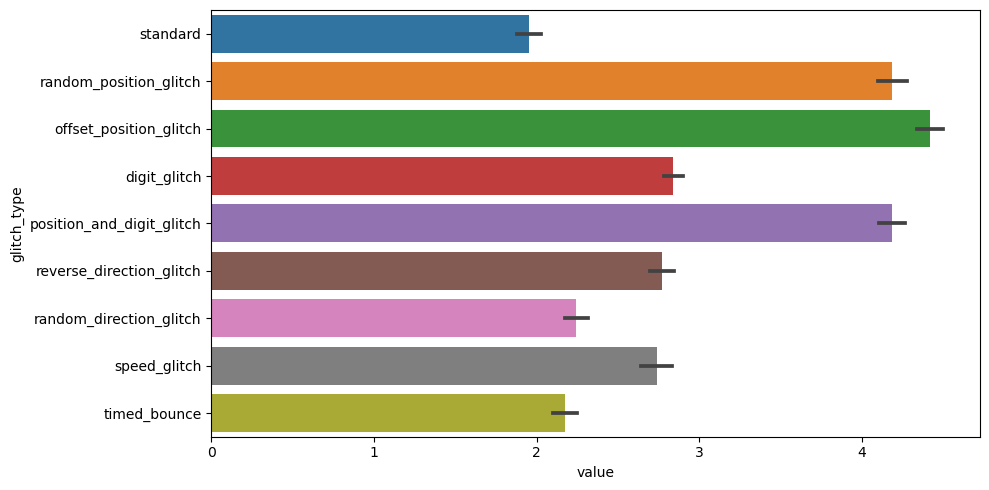

In [173]:
for key in dict_lspe_val:
    print(key, np.mean(dict_lspe_val[key]))

import pandas as pd
glitch_lspe = pd.melt(pd.DataFrame(dict_lspe_val),var_name='glitch_type')
f,ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data=glitch_lspe,x='value',y='glitch_type',errorbar='se',orient='h',ax=ax)
f.tight_layout()

f.savefig('glitch_mean_lspe.pdf',bbox_inches='tight')

### Decoding

In [5]:
# beta = 1
vae_model_path = '../../saved_models/MNIST/model_vae_2023-05-04.pt'
vae_params_path_recovery = vae_model_path[:-3]+'.params.yml'
with open(vae_params_path_recovery) as file :
    vae_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+vae_params_path_recovery)
print("beta params :",vae_parameters['beta_vae'])

vae_model_1 = VAE_64_64(img_channels=vae_parameters['img_channels_vae'],
                     latent_dim=vae_parameters['latent_dim_vae'],
                     beta=vae_parameters['beta_vae']).to(device)

vae_model_1.load_state_dict(torch.load(vae_model_path))
vae_model_1.eval()

# beta = 5
vae_model_path = '../../saved_models/MNIST/model_vae_2023-05-07.pt'
vae_params_path_recovery = vae_model_path[:-3]+'.params.yml'
with open(vae_params_path_recovery) as file :
    vae_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+vae_params_path_recovery)
print("beta params :",vae_parameters['beta_vae'])

vae_model_5 = VAE_64_64(img_channels=vae_parameters['img_channels_vae'],
                     latent_dim=vae_parameters['latent_dim_vae'],
                     beta=vae_parameters['beta_vae']).to(device)

vae_model_5.load_state_dict(torch.load(vae_model_path))
vae_model_5.eval()


# beta = 20
vae_model_path = '../../saved_models/MNIST/model_vae_2023-05-11.pt'
vae_params_path_recovery = vae_model_path[:-3]+'.params.yml'
with open(vae_params_path_recovery) as file :
    vae_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+vae_params_path_recovery)


vae_model_20 = VAE_64_64(img_channels=vae_parameters['img_channels_vae'],
                     latent_dim=vae_parameters['latent_dim_vae'],
                     beta=vae_parameters['beta_vae']).to(device)

vae_model_20.load_state_dict(torch.load(vae_model_path))
vae_model_20.eval()
print("beta params :",vae_parameters['beta_vae'])


using parameters from ../../saved_models/MNIST/model_vae_2023-05-04.params.yml
beta params : 1
using parameters from ../../saved_models/MNIST/model_vae_2023-05-07.params.yml
beta params : 5
using parameters from ../../saved_models/MNIST/model_vae_2023-05-11.params.yml
beta params : 20


In [128]:
data_train,labels = [],[]

list_timesteps_obs = [9,9,9,9,9,10,10,10,5]
for i, file in enumerate(data_files):
    data = np.load(data_path + file)
    data = data / 255
    reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(data)
    z_error = (mean_pred[:,:-1,:] - latent_video[:,1:,:])[:,list_timesteps_obs[i]-1:list_timesteps_obs[i]+2,:].reshape(100,1,-1)
    data_train.extend(np.concatenate(z_error,axis=0))
    labels.extend([i]*z_error.shape[0])


In [130]:
data_train[0].shape

(60,)

In [157]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import KFold
import sklearn
scaler = sklearn.preprocessing.StandardScaler()
data_train =scaler.fit_transform(data_train)
cv = KFold(n_splits=5,shuffle=True)
clf = RidgeClassifierCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1],cv=cv).fit(data_train, labels)
score = np.mean( [ sklearn.model_selection.cross_val_score(clf, data_train, labels, cv=cv).mean() for i in range(10)])
# score = clf.score(data_train,labels)
print(score)

0.18255555555555555


In [107]:
"""
beta = 1 score of 14.2%
beta = 5 score of 14.6% 
beta = 20 score of 18.4% 
"""

'\nbeta = 1 score of 14.2%\nbeta = 5 score of 14.6% \nbeta = 20 score of 16% \n'

In [155]:
for i, file in enumerate(data_files):
     print( file, clf.score(data_train[100*i:100*(i+1)], labels[100*i:100*(i+1)]) )

standard.npy 0.18
random_position_glitch.npy 0.32
offset_position_glitch.npy 0.32
digit_glitch.npy 0.15
position_and_digit_glitch.npy 0.33
reverse_direction_glitch.npy 0.25
random_direction_glitch.npy 0.21
speed_glitch.npy 0.41
timed_bounce.npy 0.9


In [54]:
1/9

0.1111111111111111